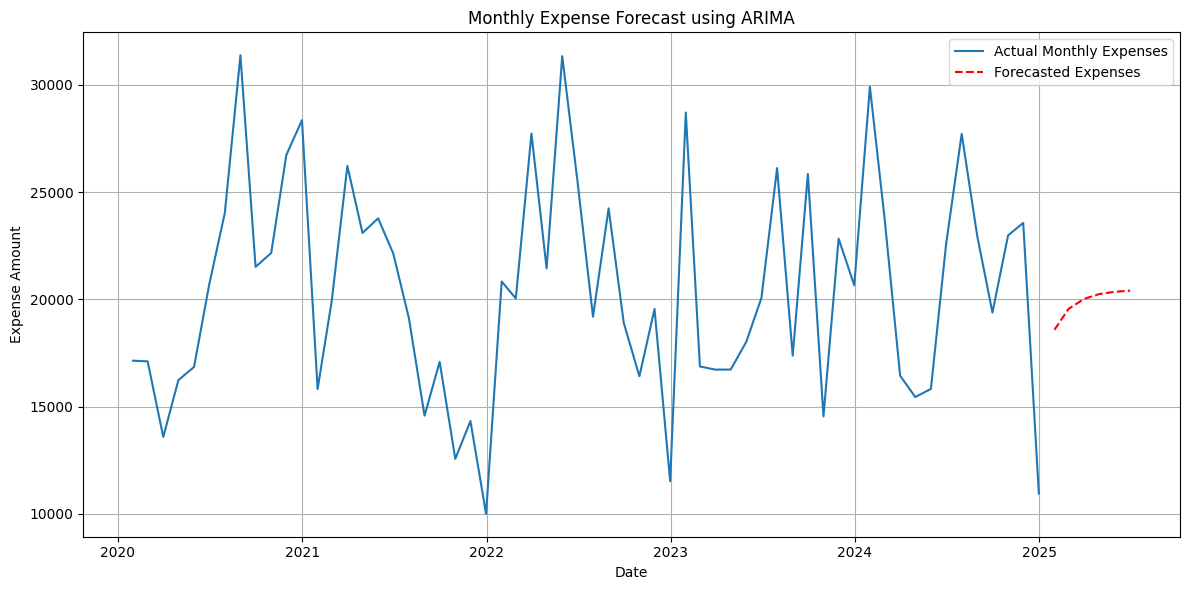

Forecast data saved to ../outputs/forecast_data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
import os

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("../data/Personal_Finance_Dataset.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter only expense transactions
df_expense = df[df['Type'] == 'Expense']

# Aggregate monthly expenses
monthly_expense = df_expense.resample('M', on='Date')['Amount'].sum()

# Check stationarity
adf_result = adfuller(monthly_expense)
is_stationary = adf_result[1] < 0.05

# Apply differencing if needed
if not is_stationary:
    monthly_expense_diff = monthly_expense.diff().dropna()
else:
    monthly_expense_diff = monthly_expense

# Fit ARIMA model
model = ARIMA(monthly_expense, order=(1, 1 if not is_stationary else 0, 1))
model_fit = model.fit()

# Forecast next 6 months
forecast = model_fit.forecast(steps=6)

# Create forecast index
last_date = monthly_expense.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot actual vs. forecasted expenses
plt.figure(figsize=(12, 6))
plt.plot(monthly_expense, label='Actual Monthly Expenses')
plt.plot(forecast_series, label='Forecasted Expenses', linestyle='--', color='red')
plt.title('Monthly Expense Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Expense Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save forecast data to CSV
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted_Expense': forecast_series.values
})

# Calculate historical average
historical_avg = monthly_expense.mean()

# Add Overspending_Alert column
forecast_df['Overspending_Alert'] = forecast_df['Forecasted_Expense'] > historical_avg



# Ensure outputs directory exists
os.makedirs("../outputs", exist_ok=True)

# Save to CSV
forecast_df.to_csv("../outputs/forecast_data.csv", index=False)
print("Forecast data saved to ../outputs/forecast_data.csv")

